In [ ]:
#!tar -xvf  '/content/drive/MyDrive/Colab Notebooks/data/imagewoof-320.tgz' -C '/content/drive/MyDrive/Colab Notebooks/data/'

In [ ]:
# Mount google drive and define locations of original, unmodified imagewoof data
from google.colab import drive, files
import os

drive.mount("/content/drive", force_remount=True)
working_dir = "/content/drive/MyDrive/Colab Notebooks/"

imagewoof_dir = os.path.join(working_dir, "data/imagewoof-320")
original_train_dir = os.path.join(imagewoof_dir, "train")
original_test_dir = os.path.join(imagewoof_dir, "val")

Mounted at /content/drive


In [ ]:
from pathlib import Path
from shutil import copyfile
from distutils.dir_util import copy_tree # import necessary to circumvent issues with using shutils.copytree in Python v3.6

# "n02088364": beagle
# "n02093754": border_terrier
# "n02099601": golden_retriever
# "n02111889": samoyed
# "n02115641": dingo
chosen_classes = {
    "n02088364": "beagle", 
    "n02093754": "border_terrier", 
    "n02099601": "golden_retriever", 
    "n02111889": "samoyed", 
    "n02115641": "dingo"
}

# Create 2 class folders that will contain all instances of their respective class
# Create 3 directories for train validate and test data
def init_run():
    Path(run_dir+"/train").mkdir(parents=True, exist_ok=True)
    Path(run_dir+"/validate").mkdir(parents=True, exist_ok=True)
    Path(run_dir+"/test").mkdir(parents=True, exist_ok=True)

    for c in chosen_classes.keys():
        Path(run_dir+"/"+chosen_classes[c]).mkdir(parents=True, exist_ok=True)
        Path(run_dir+"/train/"+chosen_classes[c]).mkdir(parents=True, exist_ok=True)
        Path(run_dir+"/validate/"+chosen_classes[c]).mkdir(parents=True, exist_ok=True)
        Path(run_dir+"/test/"+chosen_classes[c]).mkdir(parents=True, exist_ok=True)

# Only copy the classes to be used in the model to the run directory
def drop_classes():
    try:
        # Copy all images in train/class_name and val/class_name to run_dir/class_name
        for c in chosen_classes.keys():
            copy_tree(original_train_dir+"/"+c, run_dir+"/"+chosen_classes[c])
            copy_tree(original_test_dir+"/"+c, run_dir+"/"+chosen_classes[c])
    
    except Exception as e:
        print(e)

# Get a portion of data from each of the classes and put it the the appropriate dir
# Prior testing shows that the classes are perfectly balanced meaning that we can allocate the same number of each class to train validate and test dirs
def split_data():
    train_split = 810
    validate_split = train_split + 270
    test_split = validate_split + 270
    class_samples = {}
    for c in chosen_classes.keys():
        class_name = chosen_classes[c]
        class_samples[class_name] = os.listdir(run_dir+"/"+class_name)
        print("{} class {} samples".format(len(class_samples[class_name]), class_name))

        for i in range(0, train_split):
            copyfile(run_dir+"/"+class_name+"/"+class_samples[class_name][i], run_dir+"/train/"+class_name+"/"+class_samples[class_name][i])

        for i in range(train_split, validate_split):
            copyfile(run_dir+"/"+class_name+"/"+class_samples[class_name][i], run_dir+"/validate/"+class_name+"/"+class_samples[class_name][i])

        for i in range(validate_split, test_split):
            copyfile(run_dir+"/"+class_name+"/"+class_samples[class_name][i], run_dir+"/test/"+class_name+"/"+class_samples[class_name][i])

# run_dir is where data the may be manipulated during runtime is put
run_dir = os.path.join(imagewoof_dir, "run")

init_run()
# drop_classes()
# split_data()

train_dir = os.path.join(run_dir, "train")
validate_dir = os.path.join(run_dir, "validate")
test_dir = os.path.join(run_dir, "test")

In [ ]:
# Data sanity tests
# Get the total number of samples in train validate and test
def get_n_samples():
    ntrain_samples = 0
    nvalidate_samples = 0
    ntest_samples = 0 

    for c in chosen_classes:
        class_name = chosen_classes[c]
        ntrain_samples += len(os.listdir(run_dir+"/train/"+class_name))
        nvalidate_samples += len(os.listdir(run_dir+"/validate/"+class_name))
        ntest_samples += len(os.listdir(run_dir+"/test/"+class_name))

    print("Number of training samples = {}\nNumber of validation samples = {}\nNumber of testing samples = {}\n".format(ntrain_samples, nvalidate_samples, ntest_samples))

# This function ensures that there were no errors in the data splitting such that an image is more than 1 set
def build_sample_set(dir, s):
    for sample in os.listdir(dir):
        s.add(sample)

# Use set operations to make sure there are no intersections between datasets
def check_data_leaks():
    train_samples = set()
    validate_samples = set()
    test_samples = set()

    for c in chosen_classes:
        class_name = chosen_classes[c]
        build_sample_set(run_dir+"/train/"+class_name, train_samples)
        build_sample_set(run_dir+"/validate/"+class_name, validate_samples)
        build_sample_set(run_dir+"/test/"+class_name, test_samples)

    print("Intersection between train and validate: {}".format(not train_samples.isdisjoint(validate_samples)))
    print("Intersection between train and test:     {}".format(not train_samples.isdisjoint(test_samples)))
    print("Intersection between test and validate:  {}".format(not test_samples.isdisjoint(validate_samples)))

# Should be 4050 train, 1350 validate, 1350 test
get_n_samples()
# If all are false then there are no interesections/data leaks
check_data_leaks()

Number of training samples = 4050
Number of validation samples = 1350
Number of testing samples = 1350

Intersection between train and validate: False
Intersection between train and test:     False
Intersection between test and validate:  False


In [ ]:
# Imports required for core functionality
from time import time
import numpy as np
import pandas as pd

# Graphing tools
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# Fine tuning components
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K 
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Preprocess images and apply data augmentation to the train data
# Transformations to be applied: rotation, shift, shear, zoom, horizontal flip
def augment_train_data(target_size, batch_size, class_mode):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        height_shift_range=0.15,
        width_shift_range=0.15,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode="nearest"
    )

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
    )

    # No augmentation to be done to validation data
    validate_datagen = ImageDataGenerator(rescale=1./255)
    validate_gen = validate_datagen.flow_from_directory(
        validate_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    return train_gen, validate_gen

In [ ]:
# Takes in the convolutional base of a pretrained network, in this case InceptionV3
def custom_model(conv_base):
    model = Sequential()

    model.add(conv_base)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))

    # Output layer uses softmax activation function because it is a multi-classification task
    model.add(Dense(5, activation="softmax"))

    return model

In [ ]:
# compile the model
def compile_model(model, hyperparameters):
    print("Compiling model")
    model.compile(loss="categorical_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"])
    print("Model compilation complete")
    return model

In [ ]:
# Train the model
def train_model(compiled_model, train_gen, validate_gen, epochs, callbacks):
    print("Training model...")

    t0 = time()
    history = compiled_model.fit(
        train_gen,
        validation_data=validate_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    print("Training took {} seconds".format(int(time() - t0)))
    return history

Found 4050 images belonging to 5 classes.
Found 1350 images belonging to 5 classes.
Compiling model
Model compilation complete
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_10 (Flatten)        (None, 131072)            0         
                                                                 
 dropout_10 (Dropout)        (None, 131072)            0         
                                                                 
 dense_20 (Dense)            (None, 256)               33554688  
                                                                 
 dense_21 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 55,358,757
Trainable params: 33,555,973
Non-

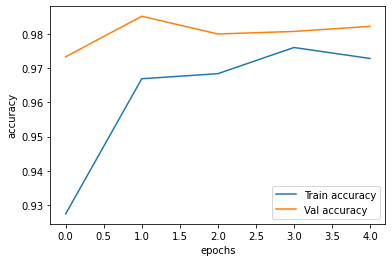

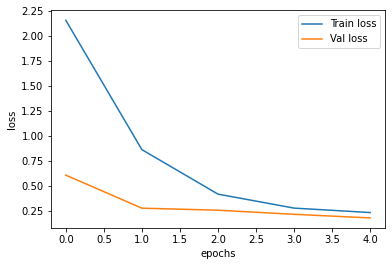

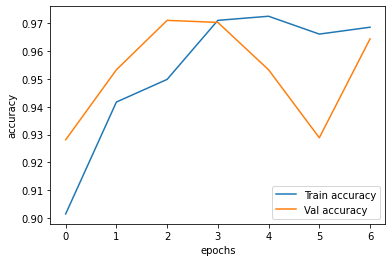

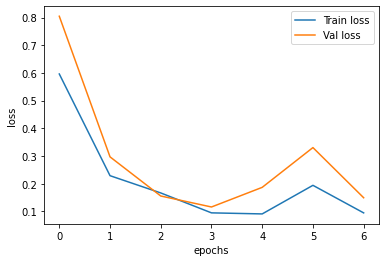

In [ ]:
# Implement transfer learing by apply fine-tuning approach
def fine_tune_training(hyperparameters):
    train_gen, val_gen = augment_train_data((299, 299), 32, "categorical")
    # Initialise InceptionV3 network with weights trained on Imagenet. Don't include top as we will be adding our own
    conv_base = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
    # print("Structure of Inception v3 convolutional base")
    # conv_base.summary()
    
    # Add custom layers to the top of the base
    model = custom_model(conv_base)

    # Freeze the InceptionV3 convolutional layers
    conv_base.trainable = False

    # Compile the model
    model = compile_model(model, hyperparameters)

    # Check model structure
    model.summary()

    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    # Train the custom classifier
    history1 = train_model(model, train_gen, val_gen, hyperparameters["feature_ex_epochs"], [early_stopping])
    plot_metrics(history1)

    # Since the last 2 blocks are being tuned, freeze the first 8 blocks. There are 31 layers per block so freeze up until 31*8 = 248
    conv_base.trainable = True
    for l in conv_base.layers[0:249]:
        l.trainable = False

    # Compile the model again
    model.compile(loss="categorical_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"])
    model.summary()
    
    # Train the model again, fine tuning the Inceptionv3 conv layers
    history2 = train_model(model, train_gen, val_gen, hyperparameters["fine_tuning_epochs"], [early_stopping])
    plot_metrics(history2)

    return model, history1, history2

hyperparameters = {
    "feature_ex_epochs": 5,
    "fine_tuning_epochs": 40,
    "optimizer": "adam",
}

model, h1, h2 = fine_tune_training(hyperparameters)

In [ ]:
def plot_metrics(history):
    validation_metrics = pd.DataFrame(history.history)
    print(validation_metrics)
    print()
    validation_metrics[["accuracy", "val_accuracy"]].plot(xlabel="epochs", ylabel="accuracy").legend(["Train accuracy", "Val accuracy"])
    validation_metrics[["loss", "val_loss"]].plot(xlabel="epochs", ylabel="loss").legend(["Train loss", "Val loss"])
    final_val_acc = validation_metrics.at[len(validation_metrics[["accuracy", "val_accuracy"]]) -1, "val_accuracy"]
    final_val_loss = validation_metrics.at[len(validation_metrics[["loss", "val_loss"]]) -1, "val_loss"]
    print("Final validation accuracy: {:.4f}".format(final_val_acc))
    print("Final validation loss:     {:.4f}".format(final_val_loss))
    print()

#plot_metrics(history1)

In [ ]:
# Do final evaluation of the model using holdout test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical"
)

test_metrics = model.evaluate(test_generator)
print("Final test accuracy: {:.4f}".format(test_metrics[1]))
print("Final test loss: {:.2f}".format(test_metrics[0]))

Found 1350 images belonging to 5 classes.
43/43 [==============================] - 8s 188ms/step - loss: 0.0980 - accuracy: 0.9726
Final test accuracy: 0.9726
Final test loss: 0.10


In [ ]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(test_generator)
predictions = np.argmax(pred, axis=1)
print("Confusion matrix: ")
confusion_matrix(test_generator.classes, predictions)

Confusion matrix: 


array([[45, 56, 51, 61, 57],
       [57, 44, 66, 52, 51],
       [53, 55, 48, 62, 52],
       [45, 51, 61, 45, 68],
       [59, 65, 54, 48, 44]])

In [ ]:
model.save("2b-dog_breed_fine_tuning.h5")

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# Classify image located in image_path with given model
def classify_image(model, image_path):
    print("Classifying image {}".format(image_path))
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert image to numpy array
    img_array = image.img_to_array(img)
    print("Shape: {}".format(img_array.shape))
    # Expand and rescale image array
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.array(img_array).astype('float32')/255
    print("Expanded Shape: {}".format(img_array.shape))
    # Make prediciton and display class
    class_names = ["beagle", "border_terrier", "dingo", "golden_retriever",  "samoyed", ]
    predicted_class = model.predict(img_array)
    print("Predicition: {}".format(class_names[np.argmax(predicted_class)]))

data_dir = os.path.join(working_dir, "data")
# model = load_model(data_dir+"/2b-dog_breed_fine_tuning.h5")
classify_image(model, data_dir+"/samoyed-1.jpg")
print()
classify_image(model, data_dir+"/retreiver-1.jpg")
print()
classify_image(model, data_dir+"/dingo-1.jpg")
print()
classify_image(model, data_dir+"/Beagle_1.jpg")
print()
classify_image(model, data_dir+"/terrier-1.jpg")
print()
classify_image(model, data_dir+"/samoyed-2.jpg")
print()
classify_image(model, data_dir+"/terrier-2.jpg")
print()
classify_image(model, data_dir+"/retreiver-2.jpg")
print()
classify_image(model, data_dir+"/samoyed-3.jpg")
print()
classify_image(model, data_dir+"/terrier-3.jpg")
print()
classify_image(model, data_dir+"/retreiver-3.jpg")

Classifying image /content/drive/MyDrive/Colab Notebooks/data/samoyed-1.jpg
Shape: (299, 299, 3)
Expanded Shape: (1, 299, 299, 3)
Predicition: samoyed

Classifying image /content/drive/MyDrive/Colab Notebooks/data/retreiver-1.jpg
Shape: (299, 299, 3)
Expanded Shape: (1, 299, 299, 3)
Predicition: golden_retriever

Classifying image /content/drive/MyDrive/Colab Notebooks/data/dingo-1.jpg
Shape: (299, 299, 3)
Expanded Shape: (1, 299, 299, 3)
Predicition: dingo

Classifying image /content/drive/MyDrive/Colab Notebooks/data/Beagle_1.jpg
Shape: (299, 299, 3)
Expanded Shape: (1, 299, 299, 3)
Predicition: beagle

Classifying image /content/drive/MyDrive/Colab Notebooks/data/terrier-1.jpg
Shape: (299, 299, 3)
Expanded Shape: (1, 299, 299, 3)
Predicition: border_terrier

Classifying image /content/drive/MyDrive/Colab Notebooks/data/samoyed-2.jpg
Shape: (299, 299, 3)
Expanded Shape: (1, 299, 299, 3)
Predicition: samoyed

Classifying image /content/drive/MyDrive/Colab Notebooks/data/terrier-2.jpg
